traitement des donnees entrainement et validatio des modele

In [119]:
import pickle as pk 
import seaborn as sns
import numpy as np 
from sklearn.model_selection import train_test_split,cross_val_score,cross_validate,GridSearchCV
import matplotlib.pyplot as plt
from sklearn.svm import SVC 
from sklearn.feature_selection import mutual_info_classif,f_classif,SelectKBest
%matplotlib inline
from sklearn.preprocessing._discretization import KBinsDiscretizer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RepeatedEditedNearestNeighbours,EditedNearestNeighbours
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score,confusion_matrix,roc_curve,auc,roc_auc_score
from sklearn.preprocessing import StandardScaler ,Normalizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.impute import KNNImputer
from scipy.stats import fisher_exact
from sklearn.tree import DecisionTreeClassifier
import warnings
from sklearn.exceptions import DataConversionWarning
from pandas.errors import SettingWithCopyWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=SettingWithCopyWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)
import pandas as pd
from scipy.stats import pearsonr
from sklearn.neighbors import NearestCentroid


preparation des fonctions

In [120]:
#train and test a model 
def test_valid(model):
    res={}
    model.fit(x_train,y_train)
    y_pred=model.predict(x_valid)
    y_pred_prob=model.predict_proba(x_valid)[:,-1]
    fpr, tpr, thresholds = roc_curve(y_true=y_valid,y_score=y_pred)
    res['recall_score']=recall_score(y_pred=y_pred,y_true=y_valid)
    res['precision_score']=precision_score(y_pred=y_pred,y_true=y_valid)
    res['accuracy_score']=accuracy_score(y_pred=y_pred,y_true=y_valid)
    res['f1_score']=f1_score(y_pred=y_pred,y_true=y_valid)
    res['auc']=roc_auc_score(y_true=y_valid,y_score=y_pred_prob)
    tn, fp, fn, tp=confusion_matrix(y_pred=y_pred,y_true=y_valid).ravel()
    print(f'tn: {tn}, fp: {fp}, fn: {fn}, tp: {tp}')
    return res  ,confusion_matrix(y_pred=y_pred,y_true=y_valid).ravel()

In [121]:
# mutual information scores 
def make_mi_scores(x, y,titre=''):
    mi_scores = mutual_info_classif(x, y,random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=x.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    dfmi=pd.DataFrame(mi_scores)
    sns.barplot(x=dfmi['MI Scores'],y=dfmi.index)
    plt.title('MI score '+titre)
    plt.show()
    return dfmi.index

In [122]:
#ANOVA F-test
def make_f_scores(x,y):
    anova_selector = SelectKBest(score_func=f_classif,k=x.columns.__len__())
    X_selected = anova_selector.fit_transform(x, y)
    feature_scores = pd.DataFrame({'Feature': x.columns, 'Score': anova_selector.scores_})
    feature_scores.sort_values(by='Score', ascending=False,inplace=True)
    sns.set(style="whitegrid")
    sns.barplot(x="Score", y="Feature", data=feature_scores)
    plt.title('ANOVA F-test')
    plt.xlabel('Feature Score')
    plt.ylabel('Feature Name')
    plt.show()


In [123]:
#print a donut shape to see distribution of class 'DEFAUT' in a datafram
def distribution_target(df,titre=""):
    plt.figure(figsize=(8,8))
    couleurs=['yellow','blue']
    plt.pie(x=[df[df['DEFAUT']==1].shape[0],df[df['DEFAUT']==0].shape[0]],colors=couleurs,explode=[0.05,0.05],shadow=False,autopct='%1.1f%%',)
    plt.legend(['defaut bancaire','non-defaut bancaire'])
    centre_circle = plt.Circle((0, 0), 0.50, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    plt.title('distribution des classe cibles'+titre)
    plt.show()


In [124]:
#calculer les ratios necessaires
def cal_ratios(df):
    df_cal=pd.DataFrame(index=df.index)
    df_cal['solvabilite']=df['CAP_PROP']/df['TOT_BL']
    df_cal['liq_immediate']=(df['LIQ'])/df['PASS_COURANT']
    df_cal['equilibire']=df['FR']/df['BFR']
    df_cal['rot_cap_prop']=df['CA']/df['CAP_PROP']
    df_cal['roe']=df['RN']/df['CAP_PROP']
    df_cal['rot_actif']=df['CA']/df['TOT_BL']
    df_cal['marge_net']=df['RN']/df['CA']
    df_cal['liq_cour']=(df['ACT_COURANT'])/df['PASS_COURANT']
    df_cal['aut_fin']=df['CAP_PROP']/(df['CAP_PROP']+df['DS'])
    df_cal['couv_det']=df['DS']/df['CFN']
    df_cal['leverage_financier']=df['PASS_COURANT']/df['CAP_PROP']
    df_cal['endettement']=df['DS']/df['FPN']
    df_cal['DEFAUT']=df['DEFAUT']
    return df_cal

In [125]:
#traiter les valeurs extremes de toutes les colonnes avant correlation
def extreme_values_1(x,col):
    d=x.copy()
    x1=d[[col]].sort_values(by=col)
    x1_min=x1[0:int(x1.__len__()*0.05)]
    x1_mid=x1[int(x1.__len__()*0.05):int(x1.__len__()*0.95)]
    x1_max=x1[int(x1.__len__()*0.95):]
    x1_max[col]=float(x1_mid.max())
    x1_min[col]=float(x1_mid.min())
    res=x1_min.append(x1_mid)
    res=res.append(x1_max)
    d[col]=res[col]
    return d

In [126]:
#traiter les valeurs extremes pour une colonne
def extreme_values(x):
    d=x.copy()
    cols=['solvabilite', 'liq_immediate', 'equilibire', 'rot_cap_prop', 'roe',
       'rot_actif', 'marge_net', 'liq_cour', 'aut_fin', 'couv_det',
       'leverage_financier', 'endettement']
    for col in cols:
        d=extreme_values_1(d,col)
    return d

In [127]:
#calculer et afficher correlation de pearson entre les variables
def corr_check(x):
    x1=extreme_values(x)
    plt.figure(figsize=(10,6))
    plt.title('correlation lineaire entre les variables' )
    sns.heatmap(x1.corr(method='pearson'),xticklabels=True,yticklabels=True,annot=True)
    plt.show()

In [128]:
#score des variable avec auc
def make_auc_scores():
    cols=['solvabilite', 'liq_immediate', 'equilibire', 'rot_cap_prop', 'roe',
        'rot_actif', 'marge_net', 'liq_cour', 'aut_fin', 'couv_det',
        'leverage_financier', 'endettement']
    res={}
    for col in cols:
        res[col]=roc_auc_score(y,x[[col]])
    scores=pd.Series(res,name='AUC SCORES')
    scores = scores.sort_values(ascending=False)
    dfauc=pd.DataFrame(scores)
    sns.barplot(x=dfauc['AUC SCORES'],y=dfauc.index)
    plt.title('AUC score des variables')
    plt.show()
    

pretraitement des donnees 


    importe dataframe a utiliser (sans valeurs nan ou aberrantes)  &  calcule des ratios

In [129]:
#importer dataframe ( les variables que je vais utiliser ) et calculer les ratios moi meme
needed_features=['NUM_CLT','CAP_PROP','TOT_BL','LIQ','PASS_COURANT','FR','BFR','CA','RN','ACT_COURANT','DS','CFN','FPN','DEFAUT']
data=pk.load(open('original_df.pickle','rb'))
print(data['description'])
df=data['dataframe'][needed_features]
df1=df
df=cal_ratios(df)


original dataframe but without nan and aberrant values


under sampling : prendre un echantillon equilibre


x=df.iloc[:,0:-1].copy()
y=df[['DEFAUT']].copy()
enn=EditedNearestNeighbours(n_neighbors=10)
smote=SMOTE(random_state=0,k_neighbors=10)
x,y=smote.fit_resample(x,y)
x,y=enn.fit_resample(x,y)

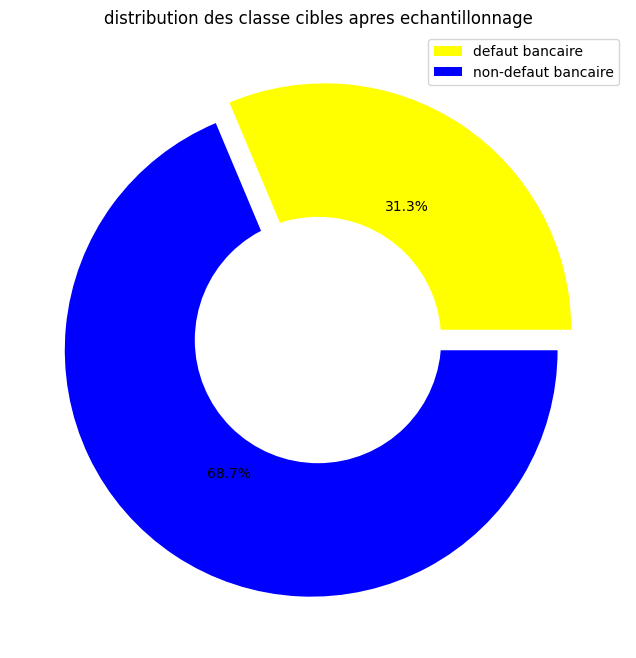

In [130]:
x=df.iloc[:,0:-1].copy()
y=df[['DEFAUT']].copy()
renn=RepeatedEditedNearestNeighbours(n_neighbors=20)
x,y=renn.fit_resample(x,y)
distribution_target(y,' apres echantillonnage')

In [131]:
y.shape

(1146, 1)

voir si il ya une correlation entres les variables avec test de pearson (formule dans le rapport)

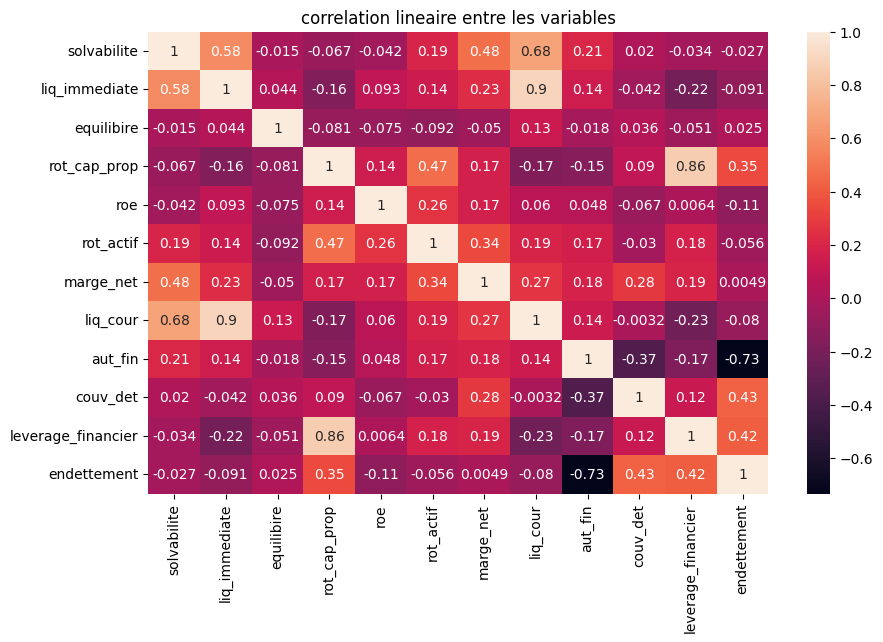

In [132]:
corr_check(x)

In [133]:
#les couples avec correlation :
corrs=[
('liq_cour','liq_immediate'),
('leverage_financier','rot_cap_prop'),
('endettement','aut_fin'),
]

calculer p-values des correlation trouvé

In [134]:
print("p-value de la correlation entre ('liq_cour','liq_immediate'): {:.2f}".format(pearsonr(x['liq_cour'],x['liq_immediate'])[1]))
print("p-value de la correlation entre ('leverage_financier','rot_cap_prop'): {:.2f}".format(pearsonr(x['leverage_financier'],x['rot_cap_prop'])[1]))
print("p-value de la correlation entre ('endettement','aut_fin'): {:.2f}".format(pearsonr(x['endettement'],x['aut_fin'])[1]))

p-value de la correlation entre ('liq_cour','liq_immediate'): 0.00
p-value de la correlation entre ('leverage_financier','rot_cap_prop'): 0.00
p-value de la correlation entre ('endettement','aut_fin'): 0.79


les correlation de ('liq_cour','liq_immediate') et ('leverage_financier','rot_cap_prop') sont significatif avec p-value < 0.05

choisir les variables avec le moins de quantite d'information pour les supprimer et enlever la correlation

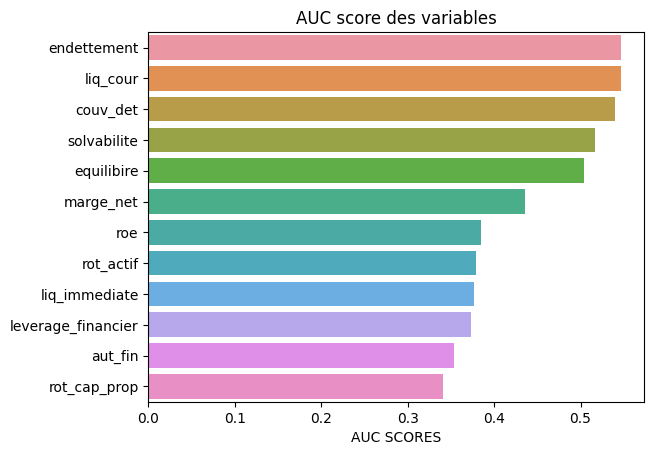

In [135]:
 #voir l'importance de variable et comperer ('liq_cour','liq_immediate') et ('leverage_financier','rot_cap_prop')
make_auc_scores()

In [136]:
to_delete=['liq_immediate','rot_cap_prop']
dropping=ColumnTransformer([('dropping','drop',to_delete)],remainder='passthrough')
scaling=Pipeline([('scale',StandardScaler())])

effet de standardisation

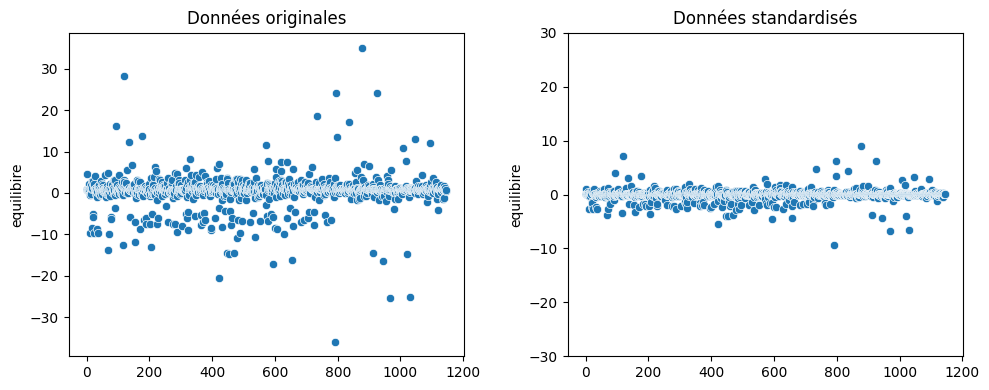

In [137]:
f="equilibire"
xx=pd.DataFrame(scaling.fit_transform(x),columns=x.columns,index=x.index)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.scatterplot(data=x[f], ax=axes[0])
axes[0].set_title('Données originales')
# Scatter plot of the scaled data
sns.scatterplot(data=xx[f], ax=axes[1])
axes[1].set_title('Données standardisés')
# Show the plot
plt.tight_layout()
plt.ylim((-30,30))
plt.show()

reel données qu'on vas travailler avec (c'est juste pour les voir mais le traitement sera fait avec des pipeline)

In [163]:
xx.drop(columns=to_delete).sample(frac=1)

,solvabilite,equilibire,roe,rot_actif,marge_net,liq_cour,aut_fin,couv_det,leverage_financier,endettement,DEFAUT
622,0.836446,0.515771,-0.086451,0.596413,0.049551,0.579250,-0.088775,0.041393,-0.373688,0.119824,0
845,0.579137,0.076750,0.372574,1.402240,0.061498,-0.109007,0.159080,-0.060642,-0.248729,-0.124976,1
913,0.564727,-3.863223,-0.049516,0.919009,0.048874,-0.136660,0.159080,-0.060642,-0.244705,-0.124976,1
265,-0.225480,-0.079230,0.010035,-0.451254,0.049906,-0.261845,-0.161897,-0.007380,0.472116,0.237347,0
781,-1.188715,0.109073,0.281298,-0.395880,0.010184,-0.327646,0.380618,-0.100539,-1.022634,-0.246359,0
...,...,...,...,...,...,...,...,...,...,...,...
376,1.442032,0.923206,-0.062754,-0.487233,0.074299,1.073524,0.159080,-0.060642,-0.382132,-0.124976,0
98,-0.003832,0.066905,0.914665,-0.143476,0.087047,-0.358611,0.091304,-0.055627,0.078110,-0.073794,0
698,0.064194,0.083755,-0.094954,0.296031,0.046171,-0.218393,0.159080,-0.060642,0.017564,-0.124976,0
1035,1.105938,0.120522,-0.137386,-0.149662,0.050549,0.231447,0.159080,-0.060642,-0.346972,-0.124976,1


    division en test train

In [138]:
x_train,x_valid,y_train,y_valid=train_test_split(x,y,test_size=0.2,random_state=2)


creation des modeles avec meilleurs parametres d'apres gridsearch

utiliser KNNImputer car il peut y avoir des valeurs NaN lors du calcule des ratios quand il y a une variable null

In [139]:
model_svc=Pipeline([('dropping',dropping),('impute',KNNImputer()),('scaling',StandardScaler()),('model',SVC(C=100,gamma=1,kernel='rbf',random_state=0,probability=True))])
svc_res,svc_cf=test_valid(model_svc)

tn: 155, fp: 8, fn: 7, tp: 60


In [140]:
model_randomForest=Pipeline([('dropping',dropping),('impute',KNNImputer()),('scaling',StandardScaler()),('model',RandomForestClassifier(500,criterion='gini',random_state=0))])
rf_res,rf_cf=test_valid(model_randomForest)

tn: 157, fp: 6, fn: 12, tp: 55


In [141]:
model_gardiantBoost=Pipeline([('dropping',dropping),('impute',KNNImputer()),('scaling',StandardScaler()),('model',XGBClassifier(objective='binary:logistic',gamma=0.5,colsample_bytree=0.75,learning_rate=0.1,max_depth=6,min_child_weight=1,n_estimators=180,subsample=1.0,random_state=0))])
gb_res,gb_cf=test_valid(model_gardiantBoost)

tn: 159, fp: 4, fn: 8, tp: 59


In [142]:
model_logisticRegression=Pipeline([('dropping',dropping),('impute',KNNImputer()),('scaling',StandardScaler()),('model',LogisticRegression(C=2.0,penalty='l1',solver='liblinear',random_state=0))])
lr_res,lr_cf=test_valid(model_logisticRegression)

tn: 159, fp: 4, fn: 53, tp: 14


In [143]:
model_neuralNetwork=Pipeline([('dropping',dropping),('impute',KNNImputer()),('scaling',StandardScaler()),('model',MLPClassifier(alpha=0.05,hidden_layer_sizes=(100,),activation='tanh',max_iter=1000,random_state=0,solver='lbfgs',learning_rate='constant'))])
nn_res,nn_cf=test_valid(model_neuralNetwork)

tn: 158, fp: 5, fn: 6, tp: 61


resultats des modeles 

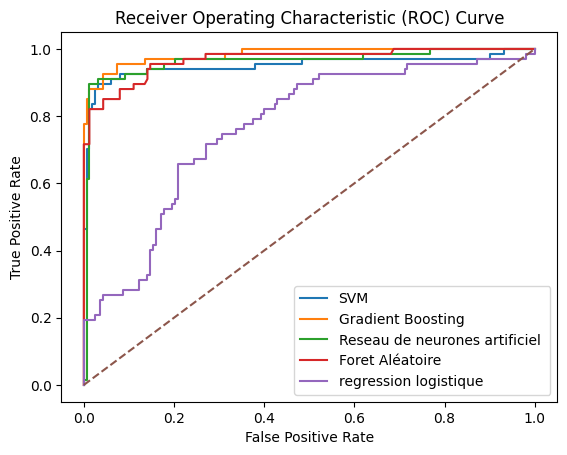

<Figure size 2000x2000 with 0 Axes>

In [150]:

predicted_probabilities_model1 = model_svc.predict_proba(x_valid)[:,-1]
predicted_probabilities_model2 = model_gardiantBoost.predict_proba(x_valid)[:,-1]
predicted_probabilities_model3 = model_neuralNetwork.predict_proba(x_valid)[:,-1]
predicted_probabilities_model4 =model_randomForest.predict_proba(x_valid)[:,-1]
predicted_probabilities_model5 = model_logisticRegression.predict_proba(x_valid)[:,-1]
true_labels = y_valid

# Compute the false positive rate, true positive rate, and thresholds for each model
fpr_model1, tpr_model1, _ = roc_curve(true_labels, predicted_probabilities_model1)
fpr_model2, tpr_model2, _ = roc_curve(true_labels, predicted_probabilities_model2)
fpr_model3, tpr_model3, _ = roc_curve(true_labels, predicted_probabilities_model3)
fpr_model4, tpr_model4, _ = roc_curve(true_labels, predicted_probabilities_model4)
fpr_model5, tpr_model5, _ = roc_curve(true_labels, predicted_probabilities_model5)

# Plot the ROC curves for each model
plt.plot(fpr_model1, tpr_model1, label='SVM')
plt.plot(fpr_model2, tpr_model2, label='Gradient Boosting ')
plt.plot(fpr_model3, tpr_model3, label='Reseau de neurones artificiel ')
plt.plot(fpr_model4, tpr_model4, label='Foret Aléatoire ')
plt.plot(fpr_model5, tpr_model5, label='regression logistique ')

# Plot the diagonal line for reference
plt.plot([0, 1], [0, 1], linestyle='--')

# Set labels, title, and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.figure(figsize=(20,20))
# Display the plot
plt.show()


In [144]:
results=pd.DataFrame({'SVC':svc_res,'gardiant boost':gb_res,'foret aleatoire':rf_res,'regression logistique':lr_res,'RNA':nn_res})
rr=results.transpose()
rr.drop(columns=['accuracy_score'])

,recall_score,precision_score,f1_score,auc
SVC,0.895522,0.882353,0.888889,0.950737
gardiant boost,0.880597,0.936508,0.907692,0.983152
foret aleatoire,0.820896,0.901639,0.859375,0.967402
regression logistique,0.208955,0.777778,0.329412,0.766505
RNA,0.910448,0.924242,0.917293,0.962549


les matrices de confusion 

In [145]:
pd.DataFrame({'SVC':svc_cf,'gardiant boost':gb_cf,'foret aleatoire':rf_cf,'regression logistique':lr_cf,'RNA':nn_cf},index=['TN','FP','FN','TP']).transpose()

,TN,FP,FN,TP
SVC,155,8,7,60
gardiant boost,159,4,8,59
foret aleatoire,157,6,12,55
regression logistique,159,4,53,14
RNA,158,5,6,61


meilleur modele obtenue neural network 

In [146]:
#enregistrer chaque modele en fichier pickle (deja execute pas besoin de le refaire)
"""pk.dump(model_gardiantBoost,open('model_gb.pkl','wb'))
pk.dump(model_logisticRegression,open('model_lr.pkl','wb'))
pk.dump(model_neuralNetwork,open('model_nn.pkl','wb'))
pk.dump(model_randomForest,open('model_rf.pkl','wb'))
pk.dump(model_svc,open('model_svc.pkl','wb'))
pk.dump(model_ncc,open('model_ncc.pkl','wb'))
"""

"pk.dump(model_gardiantBoost,open('model_gb.pkl','wb'))\npk.dump(model_logisticRegression,open('model_lr.pkl','wb'))\npk.dump(model_neuralNetwork,open('model_nn.pkl','wb'))\npk.dump(model_randomForest,open('model_rf.pkl','wb'))\npk.dump(model_svc,open('model_svc.pkl','wb'))\npk.dump(model_ncc,open('model_ncc.pkl','wb'))\n"

la validation du modele sera faite avec recall_score , precision_score , accuracy_score , f1_score et auc pour choisir le meilleur modele .
pour le site web il affiechera une probabilite pour aider ala prise de decision 
l'idee est pas besoin de choisir un seuil car l'utilisateur est celui qui prendra la decision.